# Information Retrieval 1#
## Assignment 2: Retrieval models [100 points] ##

In this assignment you will get familiar with basic and advanced information retrieval concepts. You will implement different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Wednesday, January 31st**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](piazza.com/university_of_amsterdam/spring2018/52041inr6y/home).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [1]:
import logging
import sys
import os

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        #Probe types, to make sure everything goes alright.
        assert isinstance(object_assesments[0][0], float) or \
             isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example
Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [2]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [3]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [4]:
example_document = index.document(index.document_base())
print(example_document)

('AP890425-0001', (1360, 192, 363, 0, 880, 0, 200, 0, 894, 412, 92160, 3, 192, 0, 363, 34, 1441, 0, 174134, 0, 200, 0, 894, 412, 2652, 0, 810, 107, 49, 4903, 420, 0, 1, 48, 35, 489, 0, 35, 687, 192, 243, 0, 249311, 1877, 0, 1651, 1174, 0, 2701, 117, 412, 0, 810, 391, 245233, 1225, 5838, 16, 0, 233156, 3496, 0, 393, 17, 0, 2435, 4819, 930, 0, 0, 200, 0, 894, 0, 22, 398, 145, 0, 3, 271, 115, 0, 1176, 2777, 292, 0, 725, 192, 0, 0, 50046, 0, 1901, 1130, 0, 192, 0, 408, 0, 243779, 0, 0, 553, 192, 0, 363, 0, 3747, 0, 0, 0, 0, 1176, 0, 1239, 0, 0, 1115, 17, 0, 0, 585, 192, 1963, 0, 0, 412, 54356, 0, 773, 0, 0, 0, 192, 0, 0, 1130, 0, 363, 0, 545, 192, 0, 1174, 1901, 1130, 0, 4, 398, 145, 39, 0, 577, 0, 355, 0, 491, 0, 6025, 0, 0, 193156, 88, 34, 437, 0, 0, 1852, 0, 828, 0, 1588, 0, 0, 0, 2615, 0, 0, 107, 49, 420, 0, 0, 190, 7, 714, 2701, 0, 237, 192, 157, 0, 412, 34, 437, 0, 0, 200, 6025, 26, 0, 0, 0, 0, 363, 0, 22, 398, 145, 0, 200, 638, 126222, 6018, 0, 880, 0, 0, 161, 0, 0, 319, 894, 2701, 

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [5]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:15])

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time')]


Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [6]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [7]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [8]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

Document AP890425-0001 has 13 word matches with query: "university  massachusetts".
Document AP890425-0001 and query "university  massachusetts" have a 2.5% overlap.


While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [9]:
import collections
import io
import logging
import sys

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))

OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poaching'), ('78', 'Greenpeace'

### Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand who the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [10]:
import os
from subprocess import Popen, PIPE
import shutil
import re
import pickle
import numpy as np
from scipy import stats
from gensim.models.keyedvectors import KeyedVectors
import gensim
from gensim import corpora, models
import scipy.spatial.distance as ssd
import random
import copy
from operator import itemgetter
import copy
import logging
import pyndri
import pyndri.compat
import sys
import scipy.spatial.distance as ssd
import time
from collections import Counter
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [11]:
start_time = time.time()
with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency


avg_doc_length = total_terms / num_documents
print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 47.584107875823975 seconds.


In [12]:
test_query_ids = []
with open('./ap_88_89/qrel_test', 'r') as test_queries:
    for line in test_queries:
        query_id = line.split(' ')[0]
        if query_id not in test_query_ids:
            test_query_ids.append(query_id)

valid_query_ids = []
with open('./ap_88_89/qrel_validation', 'r') as valid_queries:
    for line in valid_queries:
        query_id = line.split(' ')[0]
        if query_id not in valid_query_ids:
            valid_query_ids.append(query_id)
            
print('We have ',len(test_query_ids),' and ',len(valid_query_ids),' query ids for the test and valid sets.')

We have  120  and  30  query ids for the test and valid sets.


In [13]:
def run_retrieval(model_name,score_fn,plm_kernel="Triangle",mu=0):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    run_out_path = '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        print("File already exists")
        return
    
    retrieval_start_time = time.time()

    print('Retrieving using', model_name)
    data = {}
    count = 0
    if model_name == 'tfidf_valid' or model_name == 'BM25_valid':
        for query_id, query in queries.items():
            if query_id in valid_query_ids:
                score = 0.0
                query_word_ids = [token2id.get(query_token,0) for query_token in index.tokenize(query)] #get ids for all the words
                query_word_ids = [word_id for word_id in query_word_ids if word_id > 0] #remove stop words
                print(query_id)
                for int_doc_id in range(index.document_base(), index.maximum_document()):
                    score = 0
                    external_document_id,_ = index.document(int_doc_id) #Get the external doc id for this document
                    for query_word in query_word_ids:
                        if int_doc_id in inverted_index[query_word].keys():
                            score += score_fn(int_doc_id,query_word,collection_frequencies[query_word])
                        else: 
                            score += 0.0
                        assert(isinstance(score,float))
                    if query_id in data.keys():       
                        data[query_id].append((tuple([score,str(external_document_id)])))
                    else:
                        data[query_id] = [((tuple([score,str(external_document_id)])))]
    elif model_name == 'plm': #For the positional language models we have additional paramters we give to score_fn()
        for query_id, query in queries.items():
            if query_id in valid_query_ids:
                start = time.time()
                print(query_id,query)
                query_ids = [token2id.get(query_token,0) for query_token in index.tokenize(query)] #get ids for all the words
                query_ids = [word_id for word_id in query_ids if word_id > 0] #remove stop words
                for int_doc_id in range(index.document_base(), index.maximum_document()):
                    external_document_id,_ = index.document(int_doc_id) #Get the external doc id for this document
                    score = score_fn(int_doc_id, query_ids, plm_kernel,collection_frequencies,mu)
                    if query_id in data.keys():
                        data[query_id].append((tuple([score,str(external_document_id)])))
                    else:
                        data[query_id] = [((tuple([score,str(external_document_id)])))]
                print("Elapsed time is: ", time.time()-start)
    else: #model_name == 'JelinekMercer_valid' or model_name == 'Dirichlet_valid' or model_name == 'AbsoluteDiscounting_valid':
        for query_id, query in queries.items():
            if query_id in valid_query_ids:
                query_ids = [token2id.get(query_token,0) for query_token in index.tokenize(query)] #get ids for all the words
                query_ids = [word_id for word_id in query_ids if word_id > 0] #remove stop words  
                print(query_id, query)
                for int_doc_id in range(index.document_base(), index.maximum_document()):
                    external_document_id,_ = index.document(int_doc_id) #Get the external doc id for this document
                    score = score_fn(int_doc_id, query_ids, collection_frequencies)
                    if query_id in data.keys():       
                        data[query_id].append((tuple([score,str(external_document_id)])))
                    else:
                        data[query_id] = [((tuple([score,str(external_document_id)])))]
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

### TFIDF and BM25

In [14]:
def tfidf(int_document_id, query_term_id, document_term_freq):
    """
    Scoring function for a document and a query term using teh TFIDF model
    
    :param int_document_id: the document id
    :param query_term_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """
    try:
        score = float(np.log(1+inverted_index[query_term_id][int_document_id]) * np.log(num_documents/document_term_freq))
    except:
        score = 0
    return score

def BM25(int_document_id, query_term_id, document_term_freq): 
    """
    Scoring function for a document and a query term using the BM25 model
    
    :param int_document_id: the document id
    :param query_term_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """
    k1 = 1.2
    b = 0.75
    # We ignore the sum including k3 since our queries are typically very short and therefore this part is not needed
    score = ((k1+1)*inverted_index[query_term_id][int_document_id])/(k1*((1-b)+b*(document_lengths[int_doc_id]/avg_doc_length) \
            + inverted_index[query_term_id][int_document_id]))*(num_documents/document_term_freq)
    
    return score

#run_retrieval('tfidf_valid', tfidf)
#run_retrieval('BM25_valid', BM25)

### Langauge models

In [15]:
col_length = sum(collection_frequencies.values()) #get all counts of terms

def JelinekMercer(int_document_id, query_ids, collection_frequencies):
    """
    This function calculates the probability of a query using a LM with Jelinek Mercer smoothing
    """
    lamb = 0.9 #We have to test 0.1/0.5/0.9
    query_prob = 1
    doc_length = len([i for i in index.document(int_document_id)[1] if i >0]) #get document length of non stopwords
    for word_id in query_ids:
        try:
            word_prob = (1-lamb)*(inverted_index[word_id][int_document_id]/doc_length)
        except:
            word_prob = 0
        word_prob += lamb*(collection_frequencies[word_id]/col_length)
        query_prob *= word_prob 
    return query_prob

#run_retrieval('JelinekMercer_valid_0.9', JelinekMercer)

Results for JelinekMercer (./trec_eval -m map -m P.5 -m ndcg_cut.10 -m recall.1000 qrel_validation JelinekMercer_valid_0.1.run)

Results for $\lambda = 0.1$ are: map 0.2262, P_5 0.3733, recall_1000 0.6287 and ndcg_cut_10 0.3834.

Results for $\lambda = 0.5$ are: map 0.2249, P_5 0.4067, recall_1000 0.6226 and ndcg_cut_10 0.4011.

Results for $\lambda = 0.9$ are: map 0.1980, P_5 0.3533, recall_1000 0.5825 and ndcg_cut_10 0.3405.


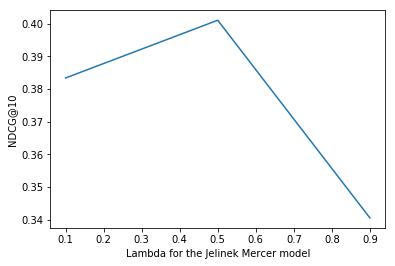

In [16]:
import matplotlib.pyplot as plt

jelinekmercer_ndcg = [0.3834, 0.4011, 0.3405]
jelinekmercer_lamb = [0.1, 0.5, 0.9]
plt.plot(jelinekmercer_lamb, jelinekmercer_ndcg)
plt.xlabel('Lambda for the Jelinek Mercer model')
plt.ylabel('NDCG@10')
plt.show()

In [17]:
def Dirichlet(int_document_id, query_ids, collection_frequencies):
    """
    This function calculates the probability of a query using a LM with Dirichlet smoothing
    """
    mu = 1500 #We have to test 500/1000/1500
    query_prob = 1
    doc_length = len([i for i in index.document(int_document_id)[1] if i >0]) #get document length of non stopwords 
    for word_id in query_ids:
        try:
            word_prob = (doc_length/(mu+doc_length))*(inverted_index[word_id][int_document_id]/doc_length)
        except:
            word_prob = 0
        word_prob += (mu/(mu+doc_length))*(collection_frequencies[word_id]/col_length)
        query_prob *= word_prob 
    return query_prob

#run_retrieval('Dirichlet_valid_1500', Dirichlet)

Results for Dirichlet (./trec_eval -m map -m P.5 -m ndcg_cut.10 -m recall.1000 qrel_validation Dirichlet_valid_0.1.run)

Results for $\mu = 500$ are: map 0.2252, P_5 0.4000, recall_1000 0.5944 and ndcg_cut_10 0.4007.

Results for $\mu = 1000$ are: map 0.2244, P_5 0.3733, recall_1000 0.5925 and ndcg_cut_10 0.3793.

Results for $\mu = 1500$ are: map 0.2233, P_5 0.3600, recall_1000 0.5854 and ndcg_cut_10 0.3732.


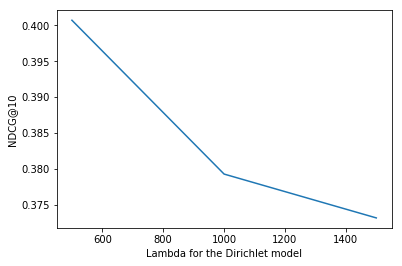

In [18]:
dirichlet_ndcg = [0.4007, 0.3793, 0.3732]
dirichlet_lamb = [500, 1000, 1500]
plt.plot(dirichlet_lamb, dirichlet_ndcg)
plt.xlabel('Lambda for the Dirichlet model')
plt.ylabel('NDCG@10')
plt.show()

In [19]:
def AbsoluteDiscounting(int_document_id, query_ids, collection_frequencies):
    """
    This function calculates the probability of a query using a LM with Absolute discounting
    """
    delta = 0.9 #We have to test 0.1/0.5/0.9
    query_prob = 1
    doc_length = len([i for i in index.document(int_document_id)[1] if i >0]) #get document length of non stopwords
    doc_unique_length = len(np.unique([i for i in index.document(int_document_id)[1] if i >0]))
    if doc_length != 0:
        sigma = delta*(doc_unique_length/doc_length) 
    else:
        sigma = delta
    for word_id in query_ids:
        try:
            word_prob = max(inverted_index[word_id][int_document_id]-delta,0)/doc_length
        except:
            word_prob = 0
        word_prob += sigma*(collection_frequencies[word_id]/col_length)
        query_prob *= word_prob 
    return query_prob

#run_retrieval('AbsoluteDiscounting_valid_0.9', AbsoluteDiscounting)

Results for Absolute discounting (./trec_eval -m map -m P.5 -m ndcg_cut.10 -m recall.1000 qrel_validation AbsoluteDiscounting_valid_0.1.run)

Results for $\delta = 0.1$ are: map 0.2180, P_5	0.3933, recall_1000 0.6145 and ndcg_cut_10 0.3791.
 
Results for $\delta = 0.5$ are: map 0.2296, P_5 0.4067, recall_1000 0.6424 and ndcg_cut_10 0.3989.

Results for $\delta = 0.9$ are: map 0.2248, P_5 0.3600, recall_1000 0.6231 and ndcg_cut_10 0.3802.


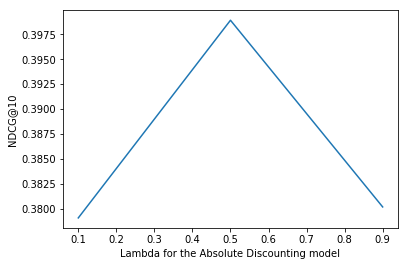

In [27]:
absdiscounting_ndcg = [0.3791, 0.3989, 0.3802]
absdiscounting_lamb = [0.1, 0.5, 0.9]
plt.plot(absdiscounting_lamb, absdiscounting_ndcg)
plt.xlabel('Lambda for the Absolute Discounting model')
plt.ylabel('NDCG@10')
plt.show()

### Positional Language Model

In [37]:
#Kernel functions
def gaussian_kernel(i,j,sigma):
    return np.exp(-(i-j)**2 / (2*sigma**2))
    
def circle_kernel(i,j,sigma):
    delta = abs(i-j) 
    if delta > sigma:
        return 0
    else:
        return np.sqrt(1-(delta/sigma)**2)
    
def triangle_kernel(i,j,sigma):
    delta = abs(i-j)
    if delta > sigma:
        return 0
    else:
        return 1 - (abs(j-1)/sigma)
    
def hamming_kernel(i,j,sigma):
    delta = abs(i-j) 
    return 0.5*(1 + np.cos(delta*np.pi/sigma))
    
def passage_kernel(i,j,sigma):
    delta = abs(i-j)
    if delta > sigma:
        return 0
    else:
        return 1

In [40]:
def plm(int_document_id,query,kernel,collection_frequencies,mu):
    """
    This functon returns the maximum value in the document using a positinal language model with 5 different kernels.
    We also use dirichlet smoothing with the paramter mu.
    """
    sigma = 50
    denom = 0
    score = 0
    scores = []
    
    unique_query_term_ids = set(query)
    _, doc_token_ids = index.document(int_document_id)
    
    if unique_query_term_ids.intersection(doc_token_ids) == 0: 
    #check if at least one query term is in the document
        return 0
    else:
        if len(doc_token_ids) == 0:
            return 0
        scores = np.zeros(len(doc_token_ids))

        if kernel == "Gaussian":
            for i in range(0,len(doc_token_ids)):
                if doc_token_ids[i] in unique_query_term_ids:
                    for j in range(0,len(doc_token_ids)):
                        score = gaussian_kernel(i,j,sigma)+mu*(collection_frequencies[doc_token_ids[i]]/total_terms)
                        denom = 1*np.exp(-(i-j)**2/(2*sigma**2))+mu
                        scores[j] += (score/denom)
                        score = 0
        else:
            for i in range(0,len(doc_token_ids)):
                if doc_token_ids[i] in unique_query_term_ids:
                    for j in range(max(0,i-50),min(i+sigma,len(doc_token_ids))): 
                    #in order to make it faster we only check the relevant indices given by sigma
                        if kernel == 'Triangle':
                            score = triangle_kernel(i,j,sigma)+mu*(collection_frequencies[doc_token_ids[i]]/total_terms)
                            denom = 1*np.exp(-(i-j)**2/(2*sigma**2))+mu
                            scores[j] += (score/denom)
                            score = 0
                        if kernel == 'Hamming':
                            score = hamming_kernel(i,j,sigma)+mu*(collection_frequencies[doc_token_ids[i]]/total_terms)
                            denom = 1*np.exp(-(i-j)**2/(2*sigma**2))+mu
                            scores[j] += (score/denom)
                            score = 0
                        if kernel == 'Circle':
                            score = circle_kernel(i,j,sigma)+mu*(collection_frequencies[doc_token_ids[i]]/total_terms)
                            denom = 1*np.exp(-(i-j)**2/(2*sigma**2))+mu
                            scores[j] += (score/denom)
                            score = 0
                        if kernel == 'Passage':
                            score = passage_kernel(i,j,sigma)+mu*(collection_frequencies[doc_token_ids[i]]/total_terms)
                            denom = 1*np.exp(-(i-j)**2/(2*sigma**2))+mu
                            scores[j] += (score/denom)
                            score = 0
    return max(scores)

run_retrieval('plm',plm)

### Significance testing

In [29]:
def plm_subprocess(plm_dict_all, plm_dict_avg, kernel, mu):
    run_retrieval('plm', plm, kernel, mu)
    shutil.move("./plm.run", "./trec_eval/plm.run")
    proc1 = Popen ('./plm.sh',shell=True,stdout = PIPE)
    out, err = proc1.communicate()
    var = out.decode('utf-8').split('\t')
    results = []
    for v in var:
        if v[:2] == '0.':
            results.append(float(v[:6]))
    name = kernel+"-"+str(mu)
    plm_dict_all[name] = results[:-1]
    plm_dict_avg[name] = results[-1]
    os.remove("./trec_eval/plm.run")
    return plm_dict_all , plm_dict_avg

In [30]:
def get_plm_data():

    plm_mu = np.arange(0,2200,200)
    kernels = ["Gaussian", "Triangle", "Hamming", "Circle", "Passage"]
    plm_dict_all = {}
    plm_dict_avg = {}

    for mu in plm_mu:
        for kernel in kernels:
            print("Evaluating the PLM model for a ",kernel," kernel and a mu of: ",mu)
            plm_dict_all, plm_dict_avg = plm_subprocess(plm_dict_all, plm_dict_avg, kernel, mu)
            with open('plm_dict_all.pickle', 'wb') as handle:
                pickle.dump(plm_dict_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
            with open('plm_dict_avg.pickle', 'wb') as handle:
                pickle.dump(plm_dict_avg, handle, protocol=pickle.HIGHEST_PROTOCOL)

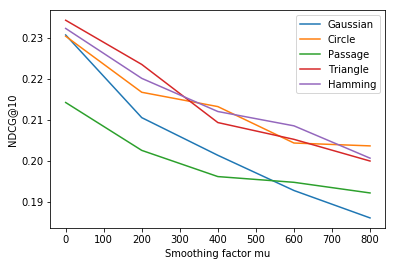

In [31]:
with open('Pickle/plm_dict_avg.pickle', 'rb') as handle:
    plm_dict_avg = pickle.load(handle)
mu_dict = {}
avg_dict = {}
for key, value in plm_dict_avg.items():
    key_split = key.split('-')
    try:
        mu_dict[key_split[0]].append(key_split[1])
        avg_dict[key_split[0]].append(value)
    except:
        mu_dict[key_split[0]] = [key_split[1]]
        avg_dict[key_split[0]] = [value]

mu_template = [0, 200, 400, 600, 800]
for key, value in avg_dict.items():
    mu = mu_dict[key]
    val = []
    for m in mu_template:
        idx = mu.index(str(m))
        val.append(value[idx])  
    plt.plot(mu_template, val, label=key)

plt.legend()
plt.ylabel('NDCG@10')
plt.xlabel('Smoothing factor mu')
plt.show()

In [32]:
def results_subprocess(model_name, results_dict):
    """
    This function is used to generate the run files we used to be able to do significane testing.
    Since this takes hours, we included the run files themselves as well as pickle dump files
    so that you are able to recreate the data if necessary
    """
    file_orig = "./"+model_name+".run"
    shutil.move(file_orig, "./trec_eval/results.run")
    proc1 = Popen ('./results.sh',shell=True,stdout = PIPE)
    out, err = proc1.communicate()
    var = out.decode('utf-8').split('\n')
    for v in var:
        split = v.split('\t')
        if len(split) == 3 and split[1] != 'all':
            try:
                results_dict[(model_name, split[0].strip())].append(float(split[2]))
            except:
                results_dict[(model_name, split[0].strip())] = [float(split[2])]
    os.remove("./trec_eval/results.run")
    with open('results_dict.pickle', 'wb') as handle:
            pickle.dump(results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return results_dict
"""
results_dict = {}
run_retrieval('tfidf', tfidf)
results_dict = results_subprocess('tfidf', results_dict)
print(results_dict)

run_retrieval('BM25', BM25)
results_dict = results_subprocess('BM25', results_dict)

run_retrieval('JelinekMercer', JelinekMercer)
results_dict = results_subprocess('JelinekMercer', results_dict)

run_retrieval('Dirichlet', Dirichlet)
results_dict = results_subprocess('Dirichlet', results_dict)

run_retrieval('AbsoluteDiscounting', AbsoluteDiscounting)
results_dict = results_subprocess('AbsoluteDiscounting', results_dict)

run_retrieval('plm', plm, "Triangle", 0)
results_dict = results_subprocess('plm', results_dict)
"""

'\nresults_dict = {}\nrun_retrieval(\'tfidf\', tfidf)\nresults_dict = results_subprocess(\'tfidf\', results_dict)\nprint(results_dict)\n\nrun_retrieval(\'BM25\', BM25)\nresults_dict = results_subprocess(\'BM25\', results_dict)\n\nrun_retrieval(\'JelinekMercer\', JelinekMercer)\nresults_dict = results_subprocess(\'JelinekMercer\', results_dict)\n\nrun_retrieval(\'Dirichlet\', Dirichlet)\nresults_dict = results_subprocess(\'Dirichlet\', results_dict)\n\nrun_retrieval(\'AbsoluteDiscounting\', AbsoluteDiscounting)\nresults_dict = results_subprocess(\'AbsoluteDiscounting\', results_dict)\n\nrun_retrieval(\'plm\', plm, "Triangle", 0)\nresults_dict = results_subprocess(\'plm\', results_dict)\n'

In [33]:
with open('Pickle/results_dict.pickle', 'rb') as handle:
    data_dict = pickle.load(handle)

def check_significance(a):
    """"
    Check significane of all models using a t-test. The alpha parameter specifies the alpha value used.
    1 is used for an alpha of 0.05, 2 for Bonferroni correction and 3 for Sidak correction.
    """
    models = ['JelinekMercer','tfidf','BM25','Dirichlet','AbsoluteDiscounting','plm']
    metrics = ['P_5','ndcg_cut_10','map','recall_1000']
    tested = []
        
    alpha = 0.05
    m = 60.0
    
    if a == 1:
        alpha = 0.05
    elif a == 2:
        alpha = alpha/m #Bonferroni correction
    elif a == 3:
        alpha = 1-(1-alpha)**(1/m) #Šidák correction

    print("Checking significance of all results with alpha equal to", alpha)
    
    for metric in metrics:
        for model1 in models:
            for model2 in models:
                if model1 != model2 and (model1,model2,metric) not in tested and (model2,model1,metric) not in tested:
                    t_test = stats.ttest_rel(data_dict[(model1,metric)], data_dict[(model2,metric)])
                    tested.append((model1,model2,metric))
                    tested.append((model2,model1,metric))
                    if t_test[1] < alpha:
                        print('T-test on %s and %s with %s gave a significant difference with a p-value of %f' % (model1,model2,metric,t_test[1]))
                        print('The means of these models and this metric are ', np.mean(data_dict[(model1,metric)]), 'for', model1, 'and' , np.mean(data_dict[(model2,metric)]), 'for', model2)
check_significance(3)

Checking significance of all results with alpha equal to 0.0008545229269492083
T-test on Dirichlet and AbsoluteDiscounting with recall_1000 gave a significant difference with a p-value of 0.000404
The means of these models and this metric are  0.5943666666666668 for Dirichlet and 0.6424199999999998 for AbsoluteDiscounting


Here we analyse the results of the t-tests conducted. When we not correct for the multiple-comparison problem we see a lot of significant results. However, when we do control for it using both Sidak an Bonferroni correction we see only one significant difference. This is with two langauge models one using Dirichlet smoothing and the other absolute discounting using the recall at 1000 evaluation metric. When we look at the values, we see that the model using absolute discounting is significantly better.

### Analyse queries

In [34]:
#First we have a look at the most significant difference between the models as found above.
valid_queries = []
for query_id, query_text in queries.items():
    if query_id in valid_query_ids:
        valid_queries.append(query_text)
        
def find_query_length_difference(model_metric_1,model_metric_2):

    length = 0  
    for query in valid_queries:
        length += len(query.split())
    print("Average query length is ",(length/len(valid_queries)))

    difference = []
    for i in range(0,len(model_metric_1)):
        difference.append(model_metric_1[i]-model_metric_2[i])

    average_difference = np.mean(difference)
    length1 = []
    length2 = []
    for i in range(0,len(difference)):
        if difference[i] > average_difference:
            length1.append(len(valid_queries[i].split()))
        elif difference[i] < average_difference:
            length2.append(len(valid_queries[i].split()))
    print('Average length of queries where model1 outperofrms model2 :',  np.mean(length1))
    print('Average length of queries where model2 outperofrms model1 :',  np.mean(length2))
 

def query_word_occurences(model_metric_1,model_metric_2):
    splitted_queries = []
    difference = []
    length1 = []
    length2 = []
    for query_id, query in queries.items():
        if query_id in valid_query_ids:
            splitted_queries.append(list(query.split()))
    query_occurences = []
    for q in splitted_queries:
        total_terms = 0
        for word in q:
            if word.lower() in token2id:
                total_terms += collection_frequencies[token2id[word.lower()]]
        query_occurences.append(total_terms/len(q))
    
    for i in range(0,len(model_metric_1)):
        difference.append(model_metric_1[i]-model_metric_2[i])
    average_difference = np.mean(difference)

    for i in range(0,len(difference)):
        if difference[i] > average_difference:
            length1.append(query_occurences[i])
        elif difference[i] < average_difference:
            length2.append(query_occurences[i])

    print('Average number of occurences of query words where model1 outperofrms model2 :',  np.mean(length1))
    print('Average number of occurences of query words when model2 outperofrms model1 :',  np.mean(length2))
    
print("Function call 1")  
find_query_length_difference(data_dict[('BM25','ndcg_cut_10')],data_dict[('tfidf','ndcg_cut_10')])
print('\n')
print("Function call 2-5")  
find_query_length_difference(data_dict[('BM25','ndcg_cut_10')],data_dict[('Dirichlet','ndcg_cut_10')])
find_query_length_difference(data_dict[('BM25','ndcg_cut_10')],data_dict[('JelinekMercer','ndcg_cut_10')])
find_query_length_difference(data_dict[('BM25','ndcg_cut_10')],data_dict[('AbsoluteDiscounting','ndcg_cut_10')])
find_query_length_difference(data_dict[('BM25','ndcg_cut_10')],data_dict[('plm','ndcg_cut_10')])
print("\n")
print("Function call 6")
find_query_length_difference(data_dict[('plm','ndcg_cut_10')],data_dict[('JelinekMercer','ndcg_cut_10')])
print("\n")
print("Function call 7-9")
query_word_occurences(data_dict[('BM25','ndcg_cut_10')],data_dict[('plm','ndcg_cut_10')])
query_word_occurences(data_dict[('BM25','ndcg_cut_10')],data_dict[('AbsoluteDiscounting','ndcg_cut_10')])
query_word_occurences(data_dict[('tfidf','ndcg_cut_10')],data_dict[('plm','ndcg_cut_10')])

Function call 1
Average query length is  5.0
Average length of queries where model1 outperofrms model2 : 5.7
Average length of queries where model2 outperofrms model1 : 3.6


Function call 2-5
Average query length is  5.0
Average length of queries where model1 outperofrms model2 : 4.7368421052631575
Average length of queries where model2 outperofrms model1 : 5.454545454545454
Average query length is  5.0
Average length of queries where model1 outperofrms model2 : 4.631578947368421
Average length of queries where model2 outperofrms model1 : 5.636363636363637
Average query length is  5.0
Average length of queries where model1 outperofrms model2 : 4.444444444444445
Average length of queries where model2 outperofrms model1 : 5.833333333333333
Average query length is  5.0
Average length of queries where model1 outperofrms model2 : 3.5454545454545454
Average length of queries where model2 outperofrms model1 : 5.842105263157895


Function call 6
Average query length is  5.0
Average length of 

### Query length
#### Function call 1:
The difference in average query length when one model wins for BM25 and TFIDF and NDCG@10 we see that BM25 is better at longer queries. This is line with expectation since this model normalizes for query length. 

#### Function call 2-5:
Here we see that language models outperform BM25 on longer queries. We are not entirely sure why this is the case, but we think this is caused by the fact that langauge models profit from more words since it becomes better at estimating the probabilities while this does not hold for BM25.

#### Function call 6:
Here we see that the positional language model works better for longer queries compared with the language model using Dirichlet smoothing. When a query only contains one word, the added value of PLM vanishes and it simply is a check whether the word occurs in a document. The longer a query gets, the more added value the PLM adds using its kernel.


### Occurences of query words in text
#### Function call 7-9:
Here we see that langauge models outperform BM25 whenever the number of occurences of the query terms in the documents is relatively high. This is in line with expectations, since these models need a lot of evidence in order to determine the (correct) probabilities of word sequences. While BM25 does not need this and therefore outperform langauge models when we have query terms that are relatively unique (do not occur very often in the collection of documents). Also interesting is that this does not hold for the TFIDF model.

### Task 2: Latent Semantic Models (LSMs) [15 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

In [35]:
# Helper cell, that returns two dictionaries. These dictionaries can be used to convert 
# docIDs to external docIDs. Internal docIDS are 1,2,3,...,164597
# external docIDs are AP-XXXXXX-XXXX

ext2int_ids = {}
int2ext_ids = {}
        
for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, _ = index.document(int_doc_id)
    ext2int_ids[ext_doc_id] = int_doc_id
    int2ext_ids[int_doc_id] = ext_doc_id
    
#print (int2ext_ids[1])
#print (ext2int_ids['AP890425-0001'])

### Retrieving the model
Training is done by creating a very large BOW representation for all the documents in the collection. These models are saved, so training has to be done only once. 

In [36]:
# A function that returns a BOW representation of the entire document set (160k documents)
# It loops through al the documents, and appends them to a list
# RETURNS
# - bow representation of the corpus
# - token2id, a dictionary for converting tokens (words) to ids
# - id2token, another dictionary for converting ids to words (tokens)

def document_bow():
    dictionary = pyndri.extract_dictionary(index) 
    token2id, id2token, _ = index.get_dictionary() # Only id2token is necessary
    documents_list = [] # The list that all the documents will be appended to
    
    for i in range(1,num_documents+1):
        _ , doc = index.document(i)
        doc = [id2token[word_id] for word_id in doc if word_id > 0]
        documents_list.append(doc)
        
    bow_corpus = [dictionary.doc2bow(text) for text in documents_list]
    return bow_corpus, token2id, id2token

corpus, token2id, id2token = document_bow()

In [37]:
def train_LDA_LSI():
    # Train LDA-model
    num_topics = 20
    lda20 = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word = id2token, passes=10)
    lda20.save('LDAmodels/LDA20')

    # Train LSI-model
    num_topics = 250
    lsi250 = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=id2token, num_topics=num_topics)
    lsi250.save('LSImodels/LSI250')

    num_topics = 500
    lsi500 = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=id2token, num_topics=num_topics)
    lsi100.save('LSImodels/LSI500')

    num_topics = 1000
    lsi1000 = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=id2token, num_topics=num_topics)
    lsi1000.save('LSImodels/LSI1000')


### Proprocessing

In [38]:
# A function that returns a document given an external doc_id
# INPUT
# - an internal doc_id, a string, for instance: APXXXXX-XX
# RETURNS
# - an list of strings representing a text, for instance ['joris','is','de','beste']
def get_document(doc_id):
    int_doc_id = ext2int_ids[doc_id]
    _,text_ids = index.document(int_doc_id)
    return [id2token[word_id] for word_id in text_ids if word_id > 0]       

In [39]:
# Function that takes returns a list of indices, converting a text into indices
# INPUT
# - a list of strings, for instance ['python','wizard']
# RETURNS
# - a list of IDS, for instance [1,2] where 'python' maps to 1, and 'wizard' maps to 2
# according to the token2id dictionary
def text_to_ind(text):
    token_ids = [token2id[token] for token in text if token in token2id] 
    return token_ids

In [40]:
# A function that generates the topic vector from a text. This can be a document or a query
# INPUT
# - a text, a list of strings, for instance ['python','wizard']
# - a model, either LSI or LDA model
# RETURNS 
# - a topic scores vector, with scores
def topic_vector_from_text(text,model):
    random.shuffle(text) # randomly shuffle text, to really create a BOW
    bow_ids = text_to_ind(text)
    bow_ids_counter = collections.Counter(bow_ids)
    bow_list = [[key,value] for key,value in bow_ids_counter.items()]
    topics_scores = model[bow_list] # topics_scores is of type: [ (1,score1),(2,score2),etc,etc]
    
    topic_ids = [topic_id for topic_id,score in topics_scores]
    topic_scores = [score for topic_id,score in topics_scores]
    num_topics = model.num_topics
    
    scores = np.zeros(num_topics)
    scores[topic_ids] = topic_scores
    return scores

In [41]:
# Function that calculates the cosine similarity between two vectors
# INPUT
# - query_topic_vec, the query topic vector
# - doc_topic_vec, the document topic vector
# RETURNS
# - the cosine similarity between query_vec and doc_vec, a float
def check_similarity(query_topic_vec,doc_topic_vec):
    return ssd.cosine(query_topic_vec,doc_topic_vec)    

In [42]:
# Function that scores a list of document-ids based on a LSI or LDA model
# INPUT
# - a model, this can be either a LSI or LDA model
# - a query, this is a list of strings, in the form ['python','wizard']
# - a list of doc_ids, of the form [APXXXXX-XX,APYYYYY-YY, etc, etc]. This list is probably of length 1000
# RETURNS
# - a list of the 1000 documents, a list of form [(APYYYYY-YY,scoreY),(APXXXXX-XX,scoreX),(etc,score_etc),...],
# , where the first element of the list is the best query result, and the last element of the list is the worst 
def lsi_lda_model_score(model,query,doc_ids):
    query_topic_vec = topic_vector_from_text(query,model)    
    
    ranking = []
    
    for ext_doc_ID in doc_ids:
        doc = get_document(ext_doc_ID) # returns the document in text
        doc_topic_vec = topic_vector_from_text(doc,model)
        score = check_similarity(query_topic_vec,doc_topic_vec)
        ranking.append((ext_doc_ID,score))
        
    ranking.sort(key=itemgetter(1))
    
    return ranking

In [43]:
# a function that reads the tfidf.run file
# INPUT
# - filename, a string
# RETURNS
# - a dictionary with takes a query_id (51,200) as value, and returns a list of a 1000 documents [APXXXX-XX,etc,...]
def read_tfidf_file(filename):
    
    return_dict = {}
    
    # Fill the dictionary with empty lists:
    # Queries go from 51 to 200
    #for i, qid in enumerate(queries):
     #   return_dict[int(qid)] = []
      #  print (qid)
        
    for qid in valid_query_ids:
        return_dict[int(qid)] = []
    
    with open(filename,'r') as fn:
        for line in fn:
            query_id = int(line.split()[0])
            ext_doc_ID = line.split()[2]
            
            temp_list = return_dict[query_id] # ugly solution this, but if its stupid but it works,
            temp_list.append(ext_doc_ID) # it aint stupid
            
            return_dict[query_id] = temp_list   
    return return_dict   

In [44]:
# A functions that appends data to a big data list
# INPUT
# - a list to_be_added, of the form [(APYYYYY-YY,scoreY),(APXXXXX-XX,scoreX),(etc,score_etc),...]
# - queryID, an integer
# - model_name a str with the model name
# - a data list of lists within a list, in which to add to_be_added
# - the lists within the list are of the form [queryID,'Q0',exc_doc_ID,rank,score,'modelname']
# RETURNS
# - data_list a list of list. Each list in the list is of the form [queryID,'Q0',ext_doc_ID,rank,score,model_name] 
def append_data(to_be_added,query_id,model_name,data_list):
    for i in range(0,len(to_be_added)):
        temp_list = []
        temp_list.append(query_id)
        temp_list.append('Q0')
        temp_list.append(to_be_added[i][0])
        temp_list.append(i+1) # rank
        temp_list.append(to_be_added[i][1])
        temp_list.append(model_name)
        data_list.append(temp_list)
    return data_list         

In [45]:
# Function that writes the data to a file
# INPUT
# - model_name, a string of the desired name of the output file
# - data, a list of list. Each list in the list is of the form [queryID,'Q0',ext_doc_ID,rank,score,model_name]
# RETURNS
# - writes data to a file, returns a file in the same folder as the .ipynb notebook
def write_model(model_name,data):
    with open(model_name,'w') as mn:
        for row in data:
            for term in row:
                mn.write(str(term) + ' ')
            mn.write('\n')
    mn.close()
    return

In [46]:
lda_model = gensim.models.ldamodel.LdaModel.load('LDAmodels/LDA20')
lsi_model = gensim.models.lsimodel.LsiModel.load('LSImodels/LSI100')

In [47]:
query_return_dict = read_tfidf_file('RunFiles/tfidf_valid.run')
#lsi_model = gensim.models.lsimodel.LsiModel.load('LSImodels/LSI250') 
lda_model = gensim.models.ldamodel.LdaModel.load('LDAmodels/LDA20')
model_name = 'LDA20.run'
data = []

for query,values in query_return_dict.items():
    query_in_text = queries[str(query)].lower().split()

    new_ranking = lsi_lda_model_score(lda_model,query_in_text,query_return_dict[query])
    data = append_data(new_ranking,int(query),model_name,data)
    
write_model(model_name,data)
print (model_name+'file created!')

LDA20.runfile created!


### Analysis

In [48]:
def write_results(model_name):
    '''
    A function that writes the result to a text file
    INPUT
    - a model_name, this can be LSI50, LSI100, LSI250, LDA10 or LDA20 or another string
    RETURNS
    - a .txt file in the folder results. Each line contains the model, the query id, and the score
    
    '''
    output_file_name = 'results'+model_name+'.txt'
    
    with open(output_file_name,'w') as file:
        
        command = './eval'+model_name + '.sh'
        proc = Popen (command,shell=True,stdout = PIPE)
        out,err = proc.communicate()
        
        result_list = out.decode('utf-8').split('\n')
        for result in result_list:
            line = result.split('\t')
            
            write_list = []
            
            for i in line:
                write_list.append(str(i))
                file.write(write_list[-1] + ' ')
            file.write('\n')
        file.close()
    return
                
#write_results('LSI50')
#write_results('LSI100')
#write_results('LSI250')
#write_results('LDA10')
#write_results('LDA20')

In [49]:
with open('Results/resultsLSI50.txt','r') as lsi50:
    
    map_scores_lsi50 = []
    p5_scores_lsi50 = []
    recall1000_scores_lsi50 = []
    ndcg10_scores_lsi50 = []
    
    for line in lsi50.readlines():
        result_line = line.split()
        if result_line != []:
            if result_line[0] == 'map' and result_line[1] != 'all' and result_line != []:
                map_scores_lsi50.append(float(result_line[-1]))
            elif result_line[0] == 'P_5' and result_line[1] != 'all':
                p5_scores_lsi50.append(float(result_line[-1]))
            elif result_line[0] == 'recall_1000' and result_line[1] != 'all':
                recall1000_scores_lsi50.append(float(result_line[-1]))
            elif result_line[0] == 'ndcg_cut_10' and result_line[1] != 'all':
                ndcg10_scores_lsi50.append(float(result_line[-1]))

with open('Results/resultsLSI250.txt','r') as lsi250:
        
    map_scores_lsi250 = []
    p5_scores_lsi250 = []
    recall1000_scores_lsi250 = []
    ndcg10_scores_lsi250 = []
    
    for line in lsi250.readlines():
        result_line = line.split()
        if result_line != []:
            if result_line[0] == 'map' and result_line[1] != 'all' and result_line != []:
                map_scores_lsi250.append(float(result_line[-1]))
            elif result_line[0] == 'P_5' and result_line[1] != 'all':
                p5_scores_lsi250.append(float(result_line[-1]))
            elif result_line[0] == 'recall_1000' and result_line[1] != 'all':
                recall1000_scores_lsi250.append(float(result_line[-1]))
            elif result_line[0] == 'ndcg_cut_10' and result_line[1] != 'all':
                ndcg10_scores_lsi250.append(float(result_line[-1]))
            
with open('Results/resultsLDA20.txt','r') as lda20:
        
    map_scores_lda20 = []
    p5_scores_lda20 = []
    recall1000_scores_lda20 = []
    ndcg10_scores_lda20 = []
    
    for line in lda20.readlines():
        result_line = line.split()
        if result_line != []:
            if result_line[0] == 'map' and result_line[1] != 'all' and result_line != []:
                map_scores_lda20.append(float(result_line[-1]))
            elif result_line[0] == 'P_5' and result_line[1] != 'all':
                p5_scores_lda20.append(float(result_line[-1]))
            elif result_line[0] == 'recall_1000' and result_line[1] != 'all':
                recall1000_scores_lda20.append(float(result_line[-1]))
            elif result_line[0] == 'ndcg_cut_10' and result_line[1] != 'all':
                ndcg10_scores_lda20.append(float(result_line[-1]))

In [83]:
#Test significance of results
data_dict[('lsi50','map')] = map_scores_lsi50
data_dict[('lsi50','P_5')] = p5_scores_lsi50
data_dict[('lsi50','recall_1000')] = recall1000_scores_lsi50
data_dict[('lsi50','ndcg_cut_10')] = ndcg10_scores_lsi50

data_dict[('lsi250','map')] = map_scores_lsi250
data_dict[('lsi250','P_5')] = p5_scores_lsi250
data_dict[('lsi250','recall_1000')] = recall1000_scores_lsi250
data_dict[('lsi250','ndcg_cut_10')]= ndcg10_scores_lsi250

data_dict[('lda20','map')] = map_scores_lda20
data_dict[('lda20','P_5')] = p5_scores_lda20
data_dict[('lda20','recall_1000')]= recall1000_scores_lda20
data_dict[('lda20','ndcg_cut_10')]= ndcg10_scores_lda20

def check_significance2(a):
    """"
    Check significane of all models using a t-test. The alpha parameter specifies the alpha value used.
    1 is used for an alpha of 0.05, 2 for Bonferroni correction and 3 for Sidak correction.
    """
    models = ['lda20','lsi250','lsi50']
    metrics = ['P_5','ndcg_cut_10','map','recall_1000']
    tested = []
        
    alpha = 0.05
    m = 60.0
    
    if a == 1:
        alpha = 0.05
    elif a == 2:
        alpha = alpha/m #Bonferroni correction
    elif a == 3:
        alpha = 1-(1-alpha)**(1/m) #Šidák correction

    print("Checking significance of all results with alpha equal to", alpha)
    
    for metric in metrics:
        for model1 in models:
            for model2 in models:
                if model1 != model2 and (model1,model2,metric) not in tested and (model2,model1,metric) not in tested:
                    t_test = stats.ttest_rel(data_dict[(model1,metric)], data_dict[(model2,metric)])
                    tested.append((model1,model2,metric))
                    tested.append((model2,model1,metric))
                    print('T-test on %s and %s with %s gave a p-value of %f' % (model1,model2,metric,t_test[1]))
check_significance2(3)

Checking significance of all results with alpha equal to 0.0008545229269492083
T-test on lda20 and lsi250 with P_5 gave a p-value of 0.325582
T-test on lda20 and lsi50 with P_5 gave a p-value of 0.662362
T-test on lsi250 and lsi50 with P_5 gave a p-value of 0.325582
T-test on lda20 and lsi250 with ndcg_cut_10 gave a p-value of 0.509607
T-test on lda20 and lsi50 with ndcg_cut_10 gave a p-value of 0.590421
T-test on lsi250 and lsi50 with ndcg_cut_10 gave a p-value of 0.833030
T-test on lda20 and lsi250 with map gave a p-value of 0.201601
T-test on lda20 and lsi50 with map gave a p-value of 0.841144
T-test on lsi250 and lsi50 with map gave a p-value of 0.174962
T-test on lda20 and lsi250 with recall_1000 gave a p-value of nan
T-test on lda20 and lsi50 with recall_1000 gave a p-value of nan
T-test on lsi250 and lsi50 with recall_1000 gave a p-value of nan
[0.6909, 0.8571, 0.8293, 0.5, 0.2857, 0.8133, 0.3801, 0.3333, 0.65, 0.1111, 0.2, 0.92, 0.7167, 1.0, 0.9212, 0.6357, 0.6538, 0.9777, 0.83

### Task 3:  Word embeddings for ranking [20 points] (open-ended) ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).
   
This is an open-ended task. It is left up you to decide how you will combine word embeddings to derive query and document representations. Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt.tar.gz). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [21]:
dictionary = pyndri.extract_dictionary(index)
sentences = pyndri.compat.IndriSentences(index, dictionary)

word_vectors = gensim.models.Word2Vec.load('W2V/w2v')

In [22]:
# Function that makes and saves a w2v model
def calculate_word2vec():
    dictionary = pyndri.extract_dictionary(index)
    sentences = pyndri.compat.IndriSentences(index, dictionary)

    word2vec = gensim.models.Word2Vec(sentences, min_count=1)
    word2vec.save('W2V/w2v')
    return

# Function that load a w2v model
def load_word2vec():
    word_vectors = gensim.models.Word2Vec.load('W2V/w2v')
    return word_vectors

# A function that returns a vector representation of a word
# INPUT
# - a word, a string, like 'joris'
# - word_vectors, a dictionary which returns the vector of a word
# CODE
# - returns the vector representation of a word. If this is not avalaible, it stems the word and finds the vector representation
# RETURNS
# - the vector representation of the (stemmed) word
def get_vector_for_word(word,word_vectors):
    try:
        embedding = word_vectors[str(word)]
        return embedding
    except KeyError:
        stemmed_word = PorterStemmer().stem(str(word))
        return word_vectors[stemmed_word]

# Function that removes punctuation, and lowers a query
# INPUT
# - a list of strings, the query, for instance ['Airbus','Subsidies']
# - token2id, a dictionary converting words to ids
# RETURNS
# - the same query lowercased without punctuation
def remove_punctuation(query,token2id):
    
    punctuation_list = ['"', '(',')', '&','-',"'",'.','/','?']
        
    good_query = []
    for word in query:           
        
        good_word = ""
        if len(word) == 1 and word in punctuation_list:
            if word == '&':
                good_query.append('and')
            else:
                continue
        elif word == 'vs' or word == 'vs.':
            good_query.append('versus')
        elif word == 'us' or word == 'U.S.' or word == "U.S.'s" or word == 'U.':
            good_query.append('united')
            good_query.append('states')
        else:
            for letter in word:
                if letter not in punctuation_list:
                    good_word += letter.lower()
                elif letter == '-' or letter == "'" or letter == '/':
                    good_query.append(good_word)
                    good_word = ""
            else:
                good_query.append(good_word)
        
    if 'us' in good_query: # Replace 'us' with 'united','states'
        place = good_query.index('us')
        good_query.pop(int(place))
        good_query.insert(int(place),'united')
        good_query.insert(int(place) + 1 , 'states')
       
    
    best_query = []
    for word in good_query:
        if word in token2id and len(word) > 1:
            best_query.append(word)
    
    return best_query

def get_document(doc_id):
    int_doc_id = ext2int_ids[doc_id]
    _,text_ids = index.document(int_doc_id)
    return [id2token[word_id] for word_id in text_ids if word_id > 0]  

In [23]:
# Function that determines the average vector of a test
# INPUT
# - a list of strings, for instance ['python','wizard']
# - a word_vectors model
# RETURNS
# - a vector of size 100
def get_average_vector(text,word_vectors):
    
    if len(text) == 0: # if the document is empty
        return np.zeros(100)
    
    average = 0
    for i in range(0,len(text)):
        if i == 0:
            average = copy.copy(get_vector_for_word(text[i],word_vectors))
        else:
            average += copy.copy(get_vector_for_word(text[i],word_vectors))
    return average/len(text)  

# Calculate the average word vector of document in the colletion
# This is a preprocessing step
# It returns a dict where dict[1] returns the average word vector of document 1
def get_doc2vec():
    doc2vec = {}

    for i in range(1,num_documents+1):
        doc_i = get_document(int2ext_ids[i])
        
        average_doc_vec = get_average_vector(doc_i,word_vectors)

        doc2vec[i] = average_doc_vec
    return doc2vec  

# Function that saves the doc2vec dictionary to a pickle file
def save_doc2vec():
    doc2vec = get_doc2vec()
    with open('doc2vec/doc2vec_dict.pickle', 'wb') as handle:
            pickle.dump(doc2vec, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return

# Function that loads the pickle doc2vec dictionary
def load_doc2vec():
    doc2vec = pickle.load(open('doc2vec/doc2vec_dict.pickle','rb'))
    return doc2vec

#doc2vec = load_doc2vec()

In [24]:
# Function that calculates the top1000 document ranking for a query
# INPUT
# - a query id, 51,200 (integer)
# - token2id, a dictionary of tokens to IDs
# - word_vectors, a dictionary of word_vectors
# RETURNS
# - a list of the 1000 documents, a list of form [(APYYYYY-YY,scoreY),(APXXXXX-XX,scoreX),(etc,score_etc),...],
# , where the first element of the list is the best query result, and the last element of the list is the worst 
def average_vector_scores(query_id,token2id,word_vectors):
    query = remove_punctuation(queries[str(query_id)].split(),token2id)
    query_vec = get_average_vector(test_query,word_vectors)
    
    ranking = []
    
    for i in range(1,num_documents+1):
        ext_doc_ID = int2ext_ids[i]
        average_doc_vec = doc2vec[i]

        score = ssd.cosine(average_query_vec,average_doc_vec)

        ranking.append((ext_doc_ID,score))
    
    ranking.sort(key=itemgetter(1))
    
    return ranking[:1000]

In [50]:
def top1000(query_ids):
    #First we get the top 1000 documents for every query
    top1000_dict = {}

    for query_id in query_ids:
        tfidf_dict = {}
        query_ids = [token2id.get(query_token,0) for query_token in index.tokenize(queries[query_id])] #get ids for all the words
        query_ids = [word_id for word_id in query_ids if word_id > 0] #remove stop words
        for int_document_id in range(index.document_base(), index.maximum_document()):
            tfidf_score = 0
            for term_id in query_ids:
                if int_document_id in inverted_index[term_id].keys():
                    tfidf_score += tfidf(int_document_id, term_id, collection_frequencies[term_id])
                else: 
                    tfidf_score += 0.0
            tfidf_dict[int_document_id] = tfidf_score

        top1000 = sorted(tfidf_dict.items(), key=lambda x:-x[1])[:1000]
        top1000_keys = [i[0] for i in top1000]
        top1000_dict[query_id] = top1000_keys

    return top1000_dict

def word2vec_most_common_words(query):
    start = time.time()
    query_words = query.split()
    query_words = remove_punctuation(query_words,token2id)
    scores = []
    query_matrix = np.zeros((len(query_words),100)) 
    for i in range(0,len(query_words)):
        try:
            query_matrix[i] = get_vector_for_word(query_words[i],word_vectors)
        except: 
            print(query_words[i])
            query_matrix[i] = [0 for i in range(0,100)] #Since word vector are trained using documents we can have new words here
    for int_doc_id in range(index.document_base(), index.maximum_document()):
        new_dict = {}
        _, doc_token_ids = index.document(int_doc_id)

        doc_counter = dict(Counter(doc_token_ids))

        relevant_word_ids = dict(Counter(doc_counter).most_common(10))
        
        if 0 in relevant_word_ids.keys():
            del relevant_word_ids[0]

        doc_words = []
        for i in relevant_word_ids:
            doc_words.append(id2token[i])

        doc_matrix = np.zeros((len(doc_words),100))  
        for i in range(0,len(doc_words)):
            doc_matrix[i] = get_vector_for_word(doc_words[i],word_vectors)

        scores.append(np.sum(np.dot(query_matrix,doc_matrix.T))/(len(query_words)))
    print("Elapsed time for ", query, " is: ", time.time() - start)

    return scores

def word2vec_best_documents(query,query_id,query_dict):
    start = time.time()
    query_words = query.split()
    query_words = remove_punctuation(query_words,token2id)
    scores = []
    query_matrix = np.zeros((len(query_words),100)) 
    for i in range(0,len(query_words)):
        try:
            query_matrix[i] = get_vector_for_word(query_words[i],word_vectors)
        except: #Since word vector are trained using documents we can have new words here
            print(query_words[i])
            query_matrix[i] = [0 for i in range(0,100)]
            
    for int_doc_id in query_dict[query_id]:
        _, doc_token_ids = index.document(int_doc_id)
        doc_words = []

        doc_counter = dict(Counter(doc_token_ids))

        relevant_word_ids = dict(Counter(doc_counter).most_common(100))
        
        if 0 in relevant_word_ids.keys():
            del relevant_word_ids[0]

        doc_words = []
        for i in relevant_word_ids:
            doc_words.append(id2token[i])
                
        doc_matrix = np.zeros((len(doc_words),100))  
        for i in range(0,len(doc_words)):
            doc_matrix[i] = get_vector_for_word(doc_words[i],word_vectors)
            
        scores.append(np.sum(np.dot(query_matrix,doc_matrix.T))/(len(query_words)))
    print("Elapsed time for ", query_id, " is: ", time.time() - start)

    return scores

In [51]:
validation_queries = {}
query_ids = []
for query_id, query_text in queries.items():
    if query_id in valid_query_ids:
        query_ids.append(query_id)
        validation_queries[query_id] = query_text
        
query_1000_dict = top1000(query_ids)

In [52]:
def word2vec_retrieval1():
    data = {}
    for query_id, query in validation_queries.items():
        if query_id in valid_query_ids:
            scores = word2vec_most_common_words(query)
            for int_doc_id in range(index.document_base(), index.maximum_document()):
                external_document_id,_ = index.document(int_doc_id)

                if query_id in data.keys():    
                    data[query_id].append((tuple([float(scores[int_doc_id-1]),str(external_document_id)])))
                else:
                    data[query_id] = [((tuple([float(scores[int_doc_id-1]),str(external_document_id)])))]
    run_out_path = '{}.run'.format('word2vec_advanced1')        
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name='word2vec_advanced',
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)
        
def word2vec_retrieval2():
    data = {}
    for key,value in validation_queries.items():
        scores = word2vec_best_documents(validation_queries[key],key,query_1000_dict)
        external_doc_ids = []
        for int_doc_id in query_1000_dict[key]:
            external_document_id,_ = index.document(int_doc_id)
            external_doc_ids.append(external_document_id)

        assert(len(scores) == len(external_doc_ids))

        for i in range(0,len(scores)):
            if query_id in data.keys():    
                data[key].append((tuple([float(scores[i]),str(external_doc_ids[i])])))
            else:
                data[key] =[((tuple([float(scores[i]),str(external_doc_ids[i])])))]

    run_out_path = '{}.run'.format('word2vec_advanced2')        
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name='word2vec_advanced',
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

In [53]:
word2vec_retrieval1()
word2vec_retrieval2()

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Elapsed time for  Computer-aided Crime  is:  57.88444113731384


KeyboardInterrupt: 

### Task 4: Learning to rank (LTR) [15 points] (open-ended) ###

In this task you will get an introduction into learning to rank for information retrieval.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1, Task 2 and Task 3 as features. Think about other features you can use (e.g. query/document length). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

You are adviced to start some pointwise learning to rank algorithm e.g. logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set. More advanced learning to rank algorithms will be appreciated when grading.

In [29]:
#First we get the top 1000 documents for every query
top1000_dict = {}

for query_id in test_query_ids:
    tfidf_dict = {}
    query_ids = [token2id.get(query_token,0) for query_token in index.tokenize(queries[query_id])] #get ids for all the words
    query_ids = [word_id for word_id in query_ids if word_id > 0] #remove stop words
    for int_document_id in range(index.document_base(), index.maximum_document()):
        tfidf_score = 0
        for term_id in query_ids:
            if int_document_id in inverted_index[term_id].keys():
                tfidf_score += tfidf(int_document_id, term_id, collection_frequencies[term_id])
            else: 
                tfidf_score += 0.0
        tfidf_dict[int_document_id] = tfidf_score

    top1000 = sorted(tfidf_dict.items(), key=lambda x:-x[1])[:1000]
    top1000_keys = [i[0] for i in top1000]
    top1000_dict[query_id] = top1000_keys

We will use the following statistics per document, query pair:
-Number of words of document. Rationale: long documents tend to be more relevant than short documents.

-Percentage of stop words. Rationale: if the text contains a lot of stop words it might be written badly or does not contain interesting words.

-Amount of unique words. Rationale: if the amount of unique words is large, the document might be very broad and covers multiple topics?

-Word count statistics: mean normalized word count, variance of normalized word count. A high mean word count means the document is very dense on a small amount of words, which might be very in depth about a topic. A low mean can have a high or low variance, if the variance is high there are a lot of words with low counts and only a couple with high counts. This might add more information of the document. 

-Scores of methods from other questions.

In [30]:
#In this cell, we get some statistics + previous scores on the documents

#Number of words 
def number_of_words(int_document_id):
    return len(index.document(int_document_id)[1])

#Percentage of stop words:
def perc_stop_words(int_document_id):
    return len([i for i in index.document(int_document_id)[1] if i == 0])/len(index.document(int_document_id)[1])

#Amount of different non stop words
def amount_of_words(int_document_id):
    return len(np.unique(index.document(int_document_id)[1]))

#Distribution of word counts
def word_count_statistics(int_document_id):
    counter = Counter(index.document(int_document_id)[1]) #make a counter dict
    total = sum(counter.values())
    for key in counter: #we normalize the counts
        counter[key] /= total 
    return np.mean(list(counter.values())), np.var(list(counter.values()))
    
def get_scores(int_document_id, query_id):
    scores = []
    query_ids = [token2id.get(query_token,0) for query_token in index.tokenize(queries[query_id])] #get ids for all the words
    query_ids = [word_id for word_id in query_ids if word_id > 0] #remove stop words
    scores.append(JelinekMercer(int_document_id, query_ids, collection_frequencies))
    scores.append(Dirichlet(int_document_id, query_ids, collection_frequencies))
    scores.append(AbsoluteDiscounting(int_document_id, query_ids, collection_frequencies))
    
    tfidf_score = 0
    bm25_score = 0
    for query_id in query_ids:
        if int_document_id in inverted_index[query_id].keys():
            tfidf_score += tfidf(int_document_id, query_id, collection_frequencies[query_id])
            bm25_score += BM25(int_document_id, query_id, collection_frequencies[query_id])
        else: 
            tfidf_score += 0.0
            bm25_score += 0.0
    scores.append(tfidf_score)
    scores.append(bm25_score)      
    scores.append(plm(int_document_id, query_ids, "Gaussian", collection_frequencies, 0))
    scores.append(plm(int_document_id, query_ids, "Passage", collection_frequencies, 0))
    scores.append(plm(int_document_id, query_ids, "Circle", collection_frequencies, 0))
    scores.append(plm(int_document_id, query_ids, "Triangle", collection_frequencies, 0))
    scores.append(plm(int_document_id, query_ids, "Hamming", collection_frequencies, 0))
    return scores

In [31]:
#Now we create a large matrix with all statistics on the documents.
def get_details(int_document_id, query_id):
    detail = []
    detail.append(number_of_words(int_document_id))
    detail.append(perc_stop_words(int_document_id))
    detail.append(amount_of_words(int_document_id))
    [detail.append(i) for i in word_count_statistics(int_document_id)]
    [detail.append(i) for i in get_scores(int_document_id, query_id)]
    return detail
details = np.zeros((1000*len(test_query_ids), len(get_details(1, query_id)))) #define an empty matrix

for q in range(0, len(test_query_ids)):
    query_id = test_query_ids[q]
    for key in range(0, 1000):
        detail = get_details(top1000_dict[query_id][key], query_id)
        for d in range(0,len(detail)):
            details[q*1000+key, d] = detail[d]

NameError: name 'plm' is not defined

As every measure has a different scale, we will normalize the data between 0-1 to have nice features for machine learning.

In [ ]:
details = (details - details.min(axis=0)) / (details.max(axis=0) - details.min(axis=0)) #normalize columns

We start by doing pointwise learning so we can treat the document ratings as targets. This way the problems becomes a regression problem. First we will generate target, then we will implement a wide range of models to slove the problem.

In [ ]:
#Here we generate target from the qrel_test file
target_dict = {}
with open('./ap_88_89/qrel_test', 'r') as test_queries:
    for line in test_queries:
        split = line.split(' ')
        query_doc_tuple = (split[0], split[2])
        target_dict[query_doc_tuple] = int(split[3][0])

targets = np.zeros(1000*len(test_query_ids)) #define an empty target array        
for q in range(0, len(test_query_ids)):
    query_id = test_query_ids[q]
    for key in range(0,1000):
        external_document_id,_ = index.document(top1000_dict[query_id][key])
        try:
            targets[q*1000+key] = target_dict[(query_id, external_document_id)]
        except:
            targets[q*1000+key] = 0 #if targets do not exist in the test set, we assume they are irrelevant
#print(targets[:100])

In [ ]:
#The first model will be a LogisticRegression
predictions1 = np.zeros(1000*len(test_query_ids))
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(details):
    X_train, X_test = details[train_index], details[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    predictions1[test_index] = lr.predict(X_test)
    print("The accuracy score for a single CV split is: ", lr.score(X_test, y_test))
    
overall_score = sum([1 for i in range(0,1000*len(test_query_ids)) if targets[i] == predictions1[i]])/(1000*len(test_query_ids))
print("The overall accuracy score is: ",overall_score)

Hmm. A 94% accuracy looks quite good. However when testing the results in trec_eval, the results are quite bad (map 0.0717, P_5	0.1333, recall_1000 0.6432, ndcg_cut_10 0.1285). This is due to the low amount of 1's, therefore the algorithm predicts almost only 0s. This makes the accuracy very high, but the relevancy very low.

In [ ]:
print("We have ",sum([1 for i in targets if i ==1])," interesting documents!")
print("This is ",sum([1 for i in targets if i ==1])/1200,"% of the selected documents!")
print("We have ",sum([1 for i in predictions1 if i ==1])," non zero predictions!")

In [ ]:
#This is a Logistic Regression including class weights, as the classes are not evenly distributed and 1s are more important for our purpose.
predictions2 = np.zeros(1000*len(test_query_ids))
proba2 = np.zeros((1000*len(test_query_ids),2))
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(details):
    X_train, X_test = details[train_index], details[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    lr = LogisticRegression(class_weight={1:0.85, 0:0.15}) #we add class weights to weigh more heavy on predicting 1.
    lr.fit(X_train, y_train)
    predictions2[test_index] = lr.predict(X_test)
    proba2[test_index] = lr.predict_proba(X_test)                   
    print("The accuracy score for a single CV split is: ", lr.score(X_test, y_test))
    
overall_score = sum([1 for i in range(0,1000*len(test_query_ids)) if targets[i] == predictions2[i]])/(1000*len(test_query_ids))
print("The overall accuracy score is: ",overall_score)
print("We have ",sum([1 for i in predictions2 if i ==1])," non zero predictions!")

What we did is that we added the class weight, to count 1s more heavily in the scoring. We can see that with ~6000 predictions, the model more closely predicts the total amount of relevant docs (~7000). Although this drops the accuracy score from 94% to 91%, the trec_eval measures improve significantly (map 0.1231, P_5 0.2800, recall_1000  0.6432 and ndcg_cut_10 0.2847).

In [ ]:
print("These are the first 20 predictions: ", list(predictions2[:20]))
print("These are the first 20 confindences: ", list(proba2[:20,1]))
pos_proba = [i for i in proba2[:20,1] if i > 0.5]
print("")
print("The positive predictions range between: ",min(pos_proba)," and ",max(pos_proba)," so there is quite some difference in prediction certainty.")

In [ ]:
#Now we want to develop tf-idf for all documents and queries only for the query tokens (we cannot handle 270K tokens for now).
unique_query_tokens = {}
for query_id, query in queries.items():
    query_word_ids = [token2id.get(query_token,0) for query_token in index.tokenize(query)] #get ids for all the words
    query_word_ids = [word_id for word_id in query_word_ids if word_id > 0] #remove stop words
    for t in query_word_ids:
        unique_query_tokens[t] = 1
query_keys = list(unique_query_tokens.keys())
print("We have ",len(query_keys)," distinct query tokens.")

tfidf_docs = np.zeros((index.maximum_document(), len(query_keys)))
print("Making doc tfidf")
for query_term in query_keys:
    idx = query_keys.index(query_term)
    col_freq = collection_frequencies[query_term]
    num_documents = index.maximum_document()
    for int_doc_id in range(index.document_base(), index.maximum_document()):
        try:
            tfidf_docs[int_doc_id, idx] = float(np.log(1+inverted_index[query_term][int_document_id]) * np.log(num_documents/col_freq))
        except:
            tfidf_docs[int_doc_id, idx] = 0

print("Making query tfidf")
tfidf_queries = np.zeros((len(test_query_ids), len(query_keys)))
for query_term in query_keys:
    idx = query_keys.index(query_term)
    col_freq = collection_frequencies[query_term]
    num_documents = index.maximum_document()
    for q in range(0, len(test_query_ids)):
        try:
            tfidf_docs[int_doc_id, idx] = float(np.log(1+inverted_index[query_term][int_document_id]) * np.log(num_documents/col_freq))
        except:
            tfidf_docs[int_doc_id, idx] = 0

Another issue is that every prediction is either 0/1, however LogisticRegression maps a value between 0-1 to a group. However we can use the confidence of being in class 1 of the LogisticRegression to score documents. This results in a significantly better scoring on trec_eval measures: map	0.2103, P_5	0.3967, recall_1000	0.6432 and ndcg_cut_10 0.3868.

In [ ]:
#This cell can put the results of the models into the .run files for evaluation.
data = {}
model_name = 'logistic_regression_weighted_prob'
for q in range(0, len(test_query_ids)):
    query_id = test_query_ids[q]
    for key in range(0,1000):
        external_document_id,_ = index.document(top1000_dict[query_id][key])
        if query_id in data.keys():       
            data[query_id].append((tuple([proba2[q*1000+key,1],str(external_document_id)])))
        else:
            data[query_id] = [((tuple([proba2[q*1000+key,1],str(external_document_id)])))]

            
run_out_path = '{}.run'.format(model_name)

if os.path.exists(run_out_path):
    print("File already exists")
else:
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

### Task 5: Write a report [15 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
